# GNN on MIMIC-III EHR

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# building the dataset
# Go to Pratip/Deep Learning Tutorial/GNN/PSG_GCN.ipynb
import os
import torch
from torch_geometric.data import Data
import networkx as nx 
from torch_geometric.utils.convert import from_networkx

os.environ['TORCH'] = torch.__version__
print(torch.__version__)
use_cuda_if_available = False


2.0.1+cpu


In [2]:
folder_path = 'Data/MIMIC resources'

df_Admissions = pd.read_csv(f'{folder_path}/ADMISSIONS.csv')

df_Patients = pd.read_csv(f'{folder_path}/PATIENTS.csv')

# medication!
df_Prescription = pd.read_csv(f'{folder_path}/PRESCRIPTIONS.csv')

# Diagnosis!
df_DiagnosisICD = pd.read_csv(f'{folder_path}/DIAGNOSES_ICD.csv')

# Procedures!
df_ProceduresICD = pd.read_csv(f'{folder_path}/PROCEDURES_ICD.csv')
# ICUStays
df_Icustays = pd.read_csv(f'{folder_path}/ICUSTAYS.csv')


df_ProceduresICD.dropna(subset=['ICD9_CODE'], inplace=True)
df_Prescription.dropna(subset=['drug'], inplace=True)
df_DiagnosisICD.dropna(subset=['ICD9_CODE'], inplace=True)

In [3]:
# convert all procedure codes into two digits only
# convert all diagnosis codes into three digits only

def extract3(code):
    return str(code)[:3]
def extract2(code):
    return str(code)[:2]

df_DiagnosisICD['ICD9_CODE'] = df_DiagnosisICD['ICD9_CODE'].apply(extract3)
df_ProceduresICD['ICD9_CODE'] = df_ProceduresICD['ICD9_CODE'].apply(extract2)

df_ProceduresICD


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,34
1,945,2592,130856,1,96
2,946,2592,130856,2,38
3,947,55357,119355,1,96
4,948,55357,119355,2,33
...,...,...,...,...,...
240090,228330,67415,150871,5,37
240091,228331,67415,150871,6,38
240092,228332,67415,150871,7,88
240093,228333,67415,150871,8,38


In [4]:
Procedures = sorted(df_ProceduresICD['ICD9_CODE'].unique())
Medication = sorted(df_Prescription['drug'].unique())
Diagnosis  = df_DiagnosisICD['ICD9_CODE'].unique()
Patients = df_Patients['SUBJECT_ID'].unique()
Admissions = df_Admissions['HADM_ID'].unique()

print(f'Number of Patients = {len(Patients)}')

print(f'Number of Admissions = {len(Admissions)}')

print(f'Number of Diagnosis = {len(Diagnosis)}')

print(f'Number of procedures = {len(Procedures)}')

print(f'Number of Medication = {len(Medication)}')

Number of Patients = 46520
Number of Admissions = 58976
Number of Diagnosis = 942
Number of procedures = 89
Number of Medication = 592


# LUNG Patients only
**ICD9=162**

In [5]:
# # restricting to LUNG disease
ICD_Diagnosis_Lung = [i for i in Diagnosis if str(i).startswith('162')]

df_sub = df_DiagnosisICD[df_DiagnosisICD['ICD9_CODE'].str.startswith('162')]


# Taking the entire dataset!
# df_sub = df_DiagnosisICD.copy()
# Display the sub dataframe
print(df_sub)

df_sub.to_csv('Data/LungPatients.csv', index=False)

        ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
584        813         103   130744      3.0       162
592        821         103   133550      3.0       162
1037       430          56   181711      2.0       162
1936      3472         291   126219      3.0       162
2541      1882         150   108732      1.0       162
...        ...         ...      ...      ...       ...
649252  638905       97301   195551      3.0       162
650147  640459       97603   166108      1.0       162
650674  632564       96004   141589      3.0       162
650784  632674       96023   116385      6.0       162
650789  632679       96023   174400      1.0       162

[1181 rows x 5 columns]


In [6]:
Patients = df_sub['SUBJECT_ID'].unique()
Admissions = df_sub['HADM_ID'].unique()

print(f'Number of Patients = {len(Patients)}')
print(f'Number of Admission = {len(Admissions)}')

Number of Patients = 998
Number of Admission = 1171


## Extracting visits (admissions) of each patient sorted by its date.

In [7]:
def getDict(A, DF, label1, label2):
    # Extracting the list of NODES for each A item. 
    # Filter the dataframe to extract Nodes associated with the specified label1
    # Extract the list of Nodes associated with the patient
    D = {}
    for v in A:
        df = DF[DF[label1] == v]
        id_list = df[label2].tolist()
        D[v] = id_list
    
    return D

# def getNodes_and_Edges(D):
#     DNodes, DEdges = [], []
#     for i, v in D.items():
#         for j in v:
#             if isinstance(j, (int, float, str)) and not np.isnan(j):
#                 DEdges.append([i,j])
#                 if j not in DNodes:
#                     DNodes.append(j)
#     return DNodes, DEdges

def getNodes_and_Edges(D):
    DEdges = []
    DNodes = []
    for i, v in D.items():
        for j in v:
            if isinstance(j, (int, float)) and not np.isnan(j):
                DEdges.append([i, j])
                if j not in DNodes:
                    DNodes.append(j)
            elif isinstance(j, str):
                # Check if it's a valid numeric string before treating it as a node
                try:
                    numeric_value = float(j)
                    DEdges.append([i, numeric_value])
                    if numeric_value not in DNodes:
                        DNodes.append(numeric_value)
                except ValueError:
                    # If it's not a valid numeric string, treat it as a regular string node
                    DEdges.append([i, j])
                    if j not in DNodes:
                        DNodes.append(j)
    return DNodes, remove_red(DEdges)

def remove_red(DEdges):
    f = []
    for u,v in DEdges:
        if [u,v] not in f:
            f.append([u,v])
    return f

In [8]:
VisitDict      = getDict(Patients, df_Admissions, 'SUBJECT_ID', 'HADM_ID')

VisitNodes, PatientVisit = getNodes_and_Edges(VisitDict)
print(f'Total number of patient-visit = {len(PatientVisit)}')


# -----------------------------------------------------------------------------
DiagnosisDict  = getDict(VisitNodes, df_DiagnosisICD, 'HADM_ID', 'ICD9_CODE')
DiagnosisNodes, VisitDiagnosis = getNodes_and_Edges(DiagnosisDict)
print(f'Total number of Visit-Diagnosis = {len(VisitDiagnosis)}')


# -----------------------------------------------------------------------------
ProcedureDict  = getDict(VisitNodes, df_ProceduresICD, 'HADM_ID', 'ICD9_CODE')
ProcedureNodes, VisitProcedure = getNodes_and_Edges(ProcedureDict)
print(f'Total number of Visit-Procedure = {len(VisitProcedure)}')


# -----------------------------------------------------------------------------
MedicationDict = getDict(VisitNodes, df_Prescription, 'hadm_id', 'drug')
MedicationNodes, VisitMedication = getNodes_and_Edges(MedicationDict)
print(f'Total number of Visit-Medication = {len(VisitMedication)}')


# -----------------------------------------------------------------------------
ICUSTAYDict = getDict(VisitNodes, df_Prescription, 'hadm_id', 'icustay_id')
ICUSTAYNodes, VisitICUSTAY = getNodes_and_Edges(ICUSTAYDict)
print(f'Total number of Visit-ICUSTAY = {len(VisitICUSTAY)}')

# # -----------------------------------------------------------------------------
# ICUSTAY_MedicationDict = getDict(ICUSTAYNodes, df_Prescription, 'icustay_id', 'drug')
# _, ICUSTAY_Medication = getNodes_and_Edges(ICUSTAY_MedicationDict)
# print(f'Total number of ICUSTAY-Medication = {len(ICUSTAY_Medication)}')

Total number of patient-visit = 1436
Total number of Visit-Diagnosis = 16818
Total number of Visit-Procedure = 4390
Total number of Visit-Medication = 334
Total number of Visit-ICUSTAY = 8


### Mapping function for Nodes and edges

In [9]:
# c, C : Patients
# v, V : visits
# d, D : Diagnosis
# p, P : Procedure
# m, M : Medication
# i, I : ICUSTAY

CV_edges = [[f'C_{u}', f'V_{v}'] for u,v in PatientVisit]
VD_edges = [[f'V_{u}', f'D_{v}'] for u,v in VisitDiagnosis]
VP_edges = [[f'V_{u}', f'P_{v}'] for u,v in VisitProcedure]
VM_edges = [[f'V_{u}', f'M_{v}'] for u,v in VisitMedication]
VI_edges = [[f'V_{u}', f'I_{v}'] for u,v in VisitICUSTAY]
# IM_edges = [[f'I_{u}', f'M_{v}'] for u,v in ICUSTAY_Medication]

In [10]:
edge_index = CV_edges + VD_edges + VP_edges + VM_edges + VI_edges

tempG = nx.Graph()
tempG.add_edges_from(edge_index)

print(len(tempG.nodes()))
Total_number_of_nodes = len(VisitNodes) + len(DiagnosisNodes) + len(ProcedureNodes) + len(MedicationNodes) + len(Patients)

Nodes = list(tempG.nodes())

3115


In [11]:
class1 = df_Admissions[df_Admissions['SUBJECT_ID'].isin(Patients)]

dead_patients = class1[class1['HOSPITAL_EXPIRE_FLAG'] == 1]['SUBJECT_ID'].tolist()
dead_patients = [f'C_{i}' for i in dead_patients]

# ----------------------------------------------------------------------------------
class2 = df_Icustays[df_Icustays['SUBJECT_ID'].isin(Patients)]

new_df = class2.groupby('SUBJECT_ID')['LOS'].sum().reset_index()
ICU = getDict(Patients, new_df, 'SUBJECT_ID', 'LOS')

In [12]:
# ICU2 = {f'C_{i}': sum(v) for i, v in ICU.items()}
# Y2 = {}
# for i in Nodes:
#     if i[0]=='C':
#         if ICU2[i]<10:
#             Y2[i] = 0
#         else:
#             Y2[i] = 1
#     else:
#         Y2[i] = 2

# Y = Y2

## Setting the nodes, edges and related data to Data 

https://stackoverflow.com/questions/70452465/how-to-load-in-graph-from-networkx-into-pytorch-geometric-and-set-node-features

In [13]:
Y = {}
for i in Nodes:
    if i[0]=='C':
        if i in dead_patients:
            Y[i] = 1
        else:
            Y[i] = 0
    else:
        Y[i] = 2


# 0 for alive patient
# 1 for dead patient
# 2 for other nodes


In [14]:
X = np.random.randn(len(Nodes), 128)
# X = np.eye(Total_number_of_nodes)

num_classes = 2
num_features = X.shape[1]

G = nx.Graph()

G.add_nodes_from([
    (v, {'y': Y[v], 'x': X[i]}) for i, v in enumerate(list(tempG.nodes()))
    ])

G.add_edges_from(edge_index)

data = from_networkx(G)


c:\Anaconda3\envs\GNNenv\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


In [15]:
mask_0_1 = (data.y == 0) | (data.y == 1)
print(mask_0_1.shape, sum([1 if v else 0 for v in mask_0_1]))

torch.Size([3115]) 998


## Creating new masks out of patient nodes only

In [16]:
data.y
newY = []
for i,v in enumerate(list(data.y)):
    if v in [0,1]:
        newY.append([i,v])

y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3, random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask = np.zeros(len(data.y), dtype=bool)
test_mask = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)
print('Train = ', sum([1 if v else 0 for v in train_mask])/998)
print('Val = ', sum([1 if v else 0 for v in val_mask])/998)
print('Test = ', sum([1 if v else 0 for v in test_mask])/998)

(3115,)
(3115,)
(3115,)
Train =  0.6993987975951904
Val =  0.10020040080160321
Test =  0.20040080160320642


In [17]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

# The Model

In [18]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    


In [19]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, average_precision_score
import torch.nn as nn

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):
    L_train, L_val, ep = [],[], []
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        # pred = out.argmax(dim=1)
        acc, val_loss = eval_node_classifier(model, graph, graph.val_mask, criterion)

        L_train.append(loss.item())
        L_val.append(val_loss)
        ep.append(epoch)
        if epoch % 10 ==0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    df = pd.DataFrame({'epoch': ep, 'Train Loss': L_train, 'Val Loss': L_val})
    return model, df


def eval_node_classifier(model, graph, mask, criterion=nn.CrossEntropyLoss()):
    model.eval()
    with torch.no_grad():
        outputs = model(graph)
        loss = criterion(outputs[mask], graph.y[mask])
        pred = outputs.argmax(dim=1)
        correct = (pred[mask] == graph.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc, loss.item()


def create_confusion_matrix(predicted, true_labels):
    # print(sum(x != y for x, y in zip(predicted, true_labels))/998)
    print(confusion_matrix(true_labels, predicted))
    print('F1 score = ', f1_score(true_labels, predicted, average='macro'))
    print('Precision score = ', precision_score(true_labels, predicted, average='macro'))
    print('AUC Precision score = ', average_precision_score(true_labels, predicted, average='macro'))
    

def plt_performance(df):
    import matplotlib.pyplot as plt
    
    # Plot the DataFrame
    plt.figure(figsize=(8, 6))
    plt.plot(df['epoch'], df['Train Loss'], label='Train Loss')
    plt.plot(df['epoch'], df['Val Loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch: 010, Train Loss: 0.500, Val Acc: 0.700
Epoch: 020, Train Loss: 0.399, Val Acc: 0.700


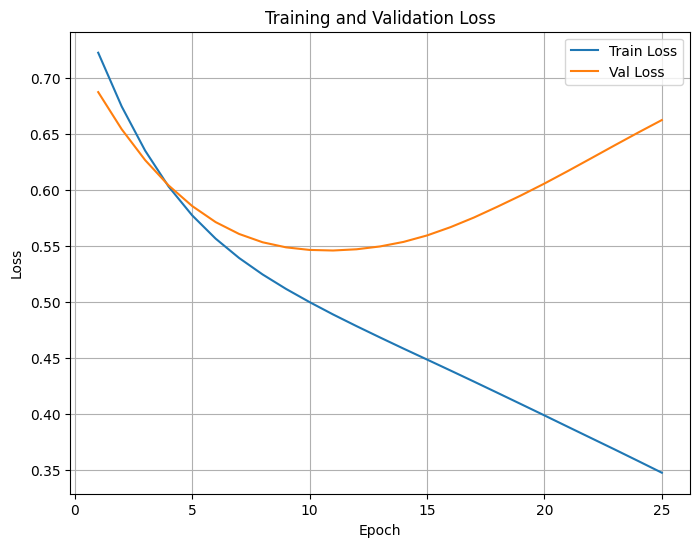

[[128  23]
 [ 41   8]]
F1 score =  0.5
Precision score =  0.5077304829165872
AUC Precision score =  0.24713298222514812
Test Acc: 0.680



In [20]:
data.x = data.x.float()
data.y = data.y.long()
data = data.to(device)
gcn = GCN().to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
gcn, df = train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=25)

plt_performance(df)
# ----------------------------------------------------------------------------
pred = gcn(data).argmax(dim=1)

pred = pred[data.test_mask] .detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

create_confusion_matrix(pred, correct)


test_acc, _ = eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}\n')